/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 [System] AI 텍스트 이펙트 프로세스 시작 (PIL Version)

🚀 [Phase 5-AI] AI 텍스트 특수 효과 생성 중 (SDXL ControlNet)...
   ... L4 GPU 성능 최적화 모델 로딩 중 (Direct CUDA) ...


Loading pipeline components...: 100%|██████████| 7/7 [00:56<00:00,  8.01s/it]


   👉 [Task B] 3D 풍선 타이틀 생성 중...


100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


   👉 [Task A] 바나나 표면 가격표 생성 중...


100%|██████████| 40/40 [00:06<00:00,  5.99it/s]


   👉 최종 합성 진행 중...


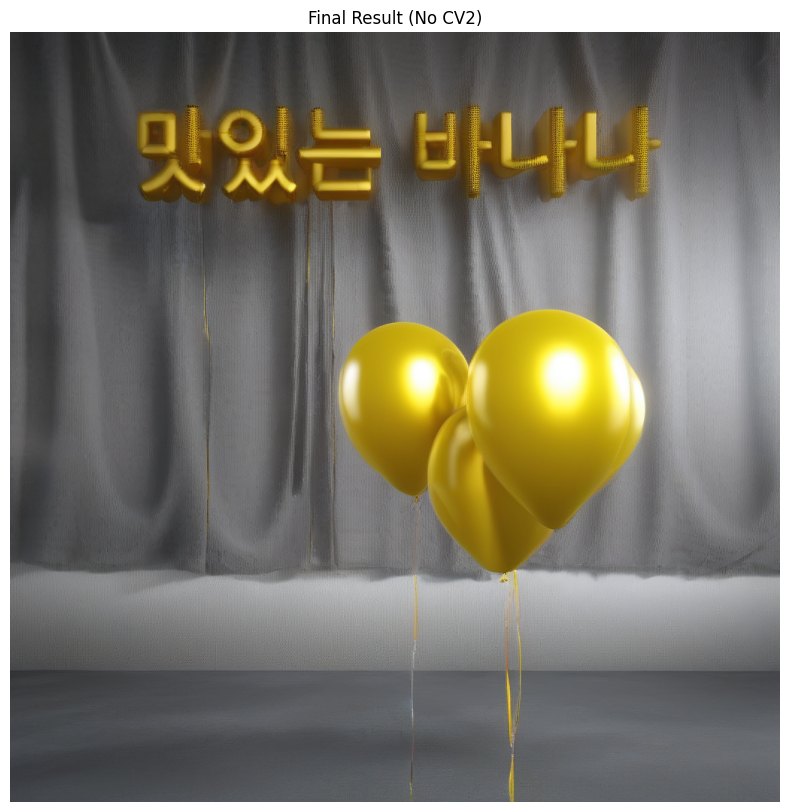

✅ 모든 작업 완료: final_ad_ai_effects.png


In [1]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
import matplotlib.pyplot as plt

# diffusers 관련 라이브러리
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image

# ⚠️ CV2 제거됨: OpenCV 대신 PIL 사용

# ==========================================
# ⚙️ 필수 설정 및 유틸리티
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.float16

def flush():
    gc.collect()
    torch.cuda.empty_cache()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

# 💡 [Fix] 좌표 계산 로직 수정 (None 처리)
def make_text_mask(text, font_size, width, height, position=None):
    font_path = download_font()
    font = ImageFont.truetype(font_path, font_size)
    img = Image.new('RGB', (width, height), (0, 0, 0))
    draw = ImageDraw.Draw(img)
    
    # 텍스트 크기 측정
    bbox = draw.textbbox((0, 0), text, font=font)
    text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    
    # 중앙 좌표 미리 계산
    center_x = (width - text_w) // 2
    center_y = (height - text_h) // 2
    
    if position is None:
        x, y = center_x, center_y
    else:
        pos_x, pos_y = position
        # 튜플 안에 None이 있으면 그 축은 중앙 정렬로 간주
        x = pos_x if pos_x is not None else center_x
        y = pos_y if pos_y is not None else center_y

    draw.text((x, y), text, font=font, fill=(255, 255, 255))
    return img, (x, y, text_w, text_h)

# 💡 OpenCV Canny 대체 함수 (PIL 사용)
def pil_make_outline(pil_image):
    gray = pil_image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

# ==========================================
# 🎨 [Task A & B] SDXL ControlNet (L4 최적화 Ver.)
# ==========================================
def run_ai_text_effects(base_image):
    print("\n🚀 [Phase 5-AI] AI 텍스트 특수 효과 생성 중 (SDXL ControlNet)...")
    
    # 1. 이전 메모리 확실히 비우기
    flush() 
    torch.cuda.ipc_collect() # 추가적인 메모리 청소

    print("   ... L4 GPU 성능 최적화 모델 로딩 중 (Direct CUDA) ...")
    
    # ControlNet 로드
    controlnet = ControlNetModel.from_pretrained(
        "diffusers/controlnet-canny-sdxl-1.0",
        torch_dtype=TORCH_DTYPE,
        use_safetensors=True
    ) # .to(DEVICE)는 파이프라인에서 한 번에 처리

    # VAE 로드
    vae = AutoencoderKL.from_pretrained(
        "madebyollin/sdxl-vae-fp16-fix", 
        torch_dtype=TORCH_DTYPE
    )

    # 파이프라인 로드
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        controlnet=controlnet,
        vae=vae,
        torch_dtype=TORCH_DTYPE
    )
    
    # ⚠️ [중요 변경] CPU Offload 대신 GPU에 바로 올립니다.
    # L4(24GB)는 SDXL을 충분히 감당하므로 이 방식이 훨씬 빠르고 안정적입니다.
    pipe.to(DEVICE) 

    W, H = base_image.size

    # ---------------------------------------------------------
    # 🎈 Task B: 입체적인 풍선 질감 타이틀
    # ---------------------------------------------------------
    print("   👉 [Task B] 3D 풍선 타이틀 생성 중...")
    
    text_guide_img, _ = make_text_mask("맛있는 바나나", 120, W, H, position=(None, 100))
    canny_image = pil_make_outline(text_guide_img)

    balloon_prompt = (
        "3D render of yellow balloon text, '맛있는 바나나', inflated shiny plastic material, "
        "helium balloon, floating, cinematic lighting, 8k, highly detailed, solid black background"
    )
    neg_prompt = "flat, 2d, paper, texture, ugly, deformed, noisy, low contrast, white background"

    balloon_text_img = pipe(
        balloon_prompt,
        negative_prompt=neg_prompt,
        image=canny_image,
        controlnet_conditioning_scale=1.0,
        num_inference_steps=40, # 퀄리티를 위해 스텝 수 약간 증가
        guidance_scale=7.5,
    ).images[0]

    # 배경 제거
    balloon_text_rgba = balloon_text_img.convert("RGBA")
    datas = balloon_text_rgba.getdata()
    new_data = []
    for item in datas:
        if item[0] < 30 and item[1] < 30 and item[2] < 30:
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    balloon_text_rgba.putdata(new_data)

    # ---------------------------------------------------------
    # 🍌 Task A: 바나나 표면에 "2500원"
    # ---------------------------------------------------------
    print("   👉 [Task A] 바나나 표면 가격표 생성 중...")
    
    crop_w, crop_h = 512, 512
    cx, cy = W // 2, int(H * 0.6)
    box = (cx - crop_w//2, cy - crop_h//2, cx + crop_w//2, cy + crop_h//2)
    
    banana_crop = base_image.crop(box)
    
    temp_crop = banana_crop.copy()
    temp_draw = ImageDraw.Draw(temp_crop)
    font_price = ImageFont.truetype(download_font(), 100)
    temp_draw.text((100, 200), "2500원", font=font_price, fill=(0,0,0))

    price_canny_img = pil_make_outline(temp_crop)

    price_prompt = (
        "Macro shot of a yellow banana skin with '2500원' written on it with a thick black permanent marker. "
        "Natural texture, organic, handwritten style, ink bleeding, realistic, high quality."
    )
    
    price_text_img = pipe(
        price_prompt,
        image=price_canny_img, 
        controlnet_conditioning_scale=0.7,
        num_inference_steps=40, # 스텝 수 증가
    ).images[0]

    # ---------------------------------------------------------
    # 🖼️ 최종 합성
    # ---------------------------------------------------------
    print("   👉 최종 합성 진행 중...")
    
    final_comp = base_image.convert("RGBA")
    
    price_text_img_resized = price_text_img.resize((crop_w, crop_h))
    final_comp.paste(price_text_img_resized, box) 
    final_comp.alpha_composite(balloon_text_rgba)

    del pipe, controlnet, vae
    flush()
    
    return final_comp.convert("RGB")

# ==========================================
# 🚀 메인 실행
# ==========================================
def process_full_ai_ad(image_path):
    print("🔄 [System] AI 텍스트 이펙트 프로세스 시작 (PIL Version)")
    
    if os.path.exists("final_ad_clean_text.png"):
        refined_image = load_image("final_ad_clean_text.png")
    else:
        # 테스트용 노란 배경
        refined_image = Image.new("RGB", (1024, 1024), "#F4E04D") 

    # Try-Except 제거함: 에러 발생 시 Traceback이 그대로 출력됩니다.
    final_result_ai = run_ai_text_effects(refined_image)
    
    final_result_ai.save("final_ad_ai_effects.png")
    
    plt.figure(figsize=(10, 10))
    plt.imshow(final_result_ai)
    plt.axis('off')
    plt.title("Final Result (No CV2)")
    plt.show()
    print("✅ 모든 작업 완료: final_ad_ai_effects.png")

# 실행
process_full_ai_ad("image.png")